In [1]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

## define helper functions

In [2]:
# define a function to gather positions
def get_pos(n_x, n_y):
    # create the hex lattice
    xs = np.array([np.arange(0, n_x) + 0.5 if idx % 2 == 0 else np.arange(0, n_x) for idx in range(n_y)])
    # derive the y-step given a distance of one
    y_step = np.sqrt(1**2+0.5**2)
    ys = np.array([[y_step * idy] * n_x for idy in range(n_y)])
    # define the positions
    pos = np.vstack([xs.flatten(), ys.flatten()]).T
    return pos

In [3]:
# define a function to derive the gex from the sphex
def calc_gex(sphex):
    """
    Calculates the gene expression matrix from the spherical
    """
    # setup the gex
    n_genes = sphex.shape[1]+1
    gex = torch.from_numpy(np.zeros((sphex.shape[0], n_genes)).astype('float32'))
    # compute the gex
    for idx in range(n_genes):
        if idx == n_genes-1:
            gex[:,idx] = torch.sin(sphex[:,idx-1])
        else:
            gex[:,idx] = torch.cos(sphex[:,idx])
        for idx_ in range(idx):
            gex[:,idx] *= torch.sin(sphex[:,idx_])
    return gex

In [4]:
from torch_geometric.nn import GCNConv
from sklearn.neighbors import kneighbors_graph
# define the number of neighbors (six for visium)
n_neighbors = 6
# define the simcomen class
class simcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(simcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.sphex = None
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=False)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(n_genes).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=False)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_sphex(self, sphex):
        """
        Artifically sets the current sphex matrix
        """
        self.sphex = torch.nn.Parameter(sphex, requires_grad=True)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the gex
        self.gex = calc_gex(self.sphex)
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [5]:
# define the celcomen class
class celcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(celcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=True)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g)).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=True)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_gex(self, gex):
        """
        Artifically sets the current sphex matrix
        """
        self.gex = torch.nn.Parameter(gex, requires_grad=False)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [6]:
# define a function to normalize the g2g
def normalize_g2g(g2g):
    """
    Addresses any small fluctuations in symmetrical weights
    """
    # symmetrize the values
    g2g = (g2g + g2g.T) / 2
    # force them to be between 0-1
    g2g[g2g < 0] = 0
    g2g[g2g > 1] = 1
    # force the central line to be 1
    for idx in range(len(g2g)):
        g2g[idx, idx] = 1
    return g2g

## learn fetal spleen immune data

/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


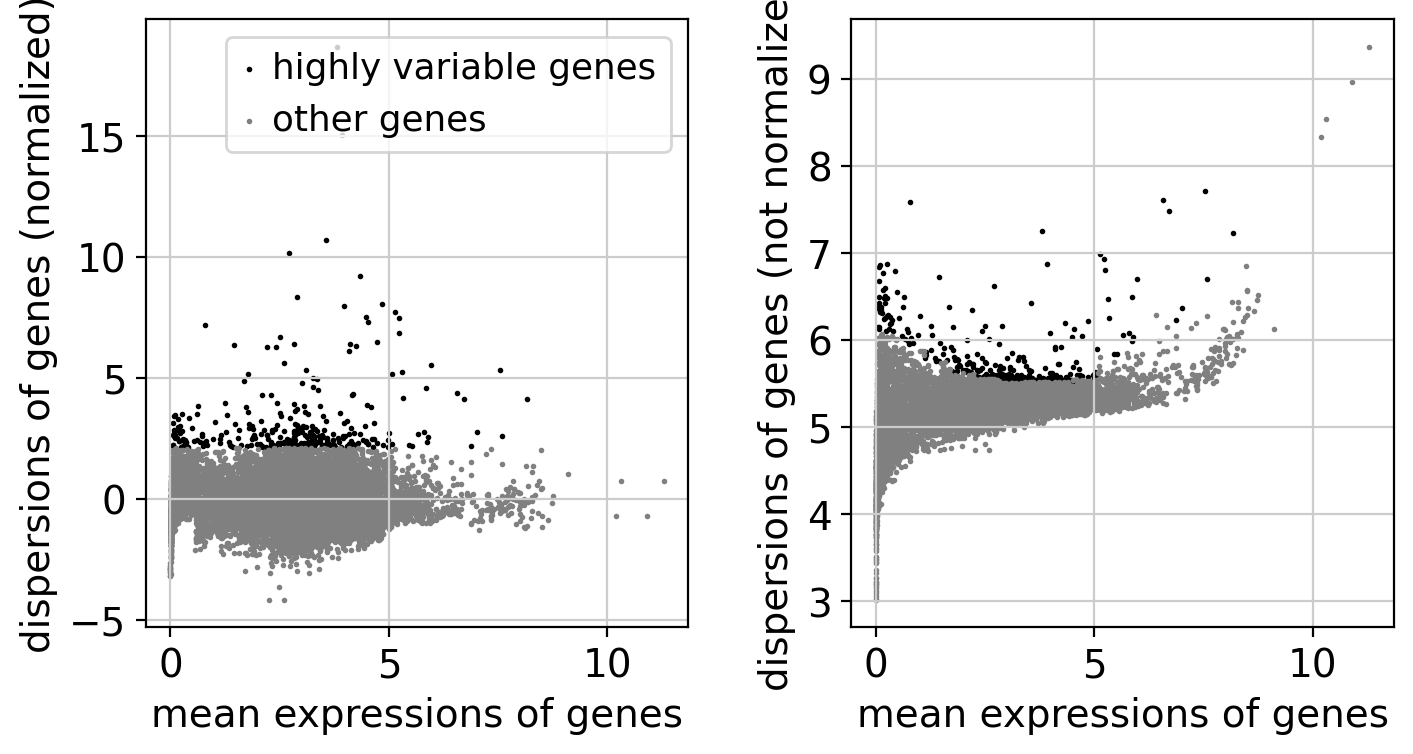

there are 300 hvgs


In [8]:
# read in the data
avis = sc.read_h5ad('../ccc/data/external/fetalimmune/Visium10X_data_SP.h5ad')
avis.var_names = avis.var_names.astype(str)
avis.var_names_make_unique()
# compute PCA for the spatial dataset using HVGs
avis.uns['log1p']['base'] = np.e
sc.pp.highly_variable_genes(avis, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5, n_top_genes=300)
sc.pl.highly_variable_genes(avis)
# define the sample indexing
sample_col = 'sample_id'
samples = avis.obs[sample_col].unique()
# report how many HVGs we're going to use
print('there are', avis.var['highly_variable'].sum(), 'hvgs')
# create a gene subset for testing
genes = avis.var_names[avis.var['highly_variable']].tolist()

In [9]:
# create a tracking variable of the datas for the dataloader
data_list = []
# loop through each sample
for sample in samples:
    # define the mask
    mask = avis.obs[sample_col] == sample
    # retrieve positions from the data
    pos = torch.from_numpy(avis[mask].obsm['spatial'])
    # convert the gene expression data to numpy
    x = torch.from_numpy(avis[mask, genes].X.todense())
    # sphere normalize the data (just in case)
    norm_factor = torch.pow(x, 2).sum(1).reshape(-1,1)
    assert (norm_factor > 0).all()
    x = torch.div(x, norm_factor)
    y = torch.Tensor([0])  # here we will store GT value
    # find the edges via kneighbors, not including self because we are considering intercellular
    edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
    edge_index = torch.from_numpy(np.array(np.where(edge_index)))
    # create the final torch geometric graph dataframe
    data = torch_geometric.data.Data(x=x, pos=pos, y=y, edge_index=edge_index)
    data.validate(raise_on_error=True)  # performs basic checks on the graph
    # store the data in the data list tracker
    data_list.append(data)
# convert into a data loader
data_loader = DataLoader(data_list, batch_size=1, shuffle=True)

In [10]:
from tqdm import tqdm
# define the parameters of the model
n_genes = len(genes)
learning_rate = 5e-2
learning_rate_all = 5e-2
zmft_scalar = 1e-1
seed = 0
epochs = 50

100%|███████████████████████████████████████████| 50/50 [01:18<00:00,  1.56s/it]


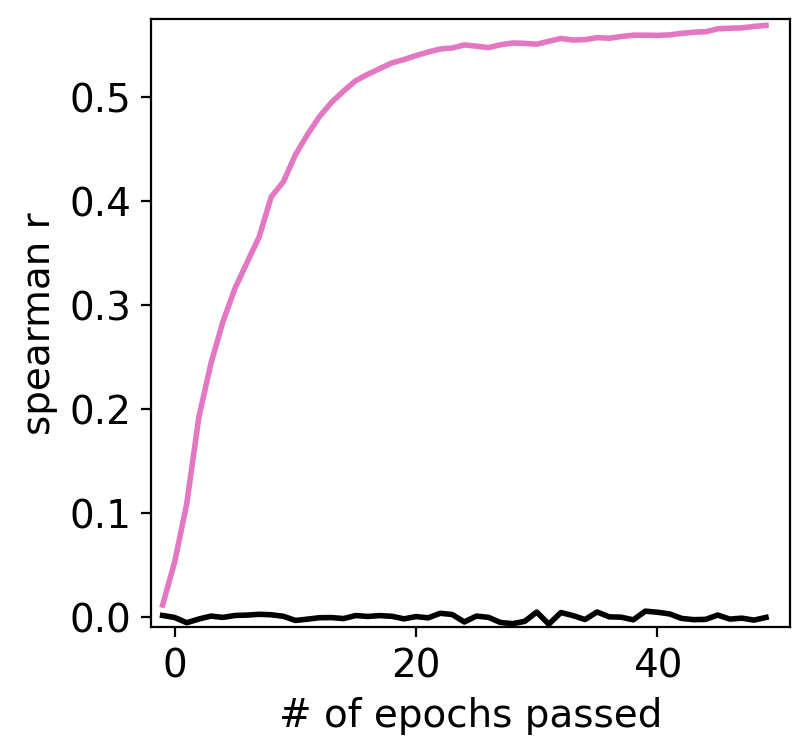

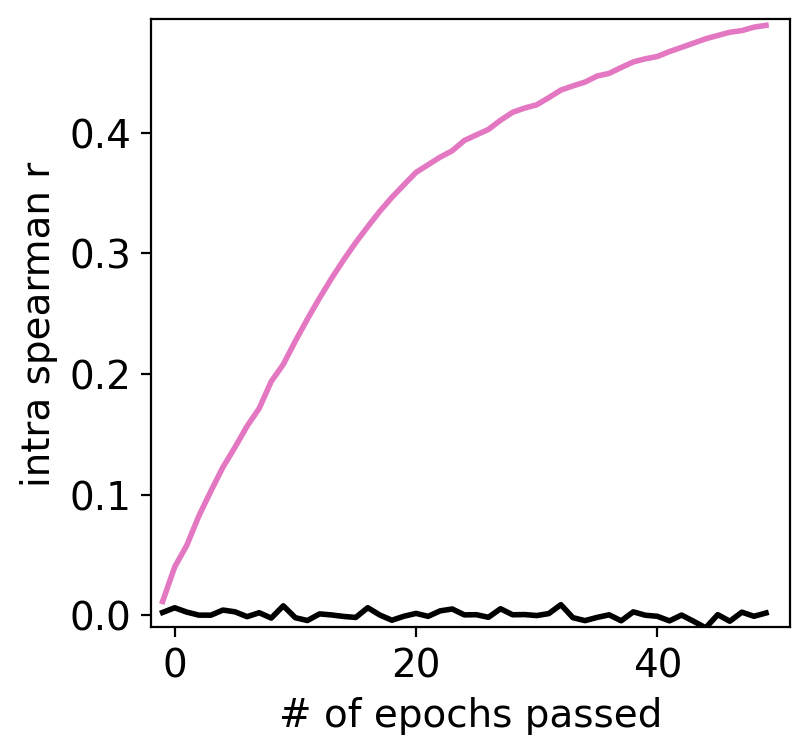

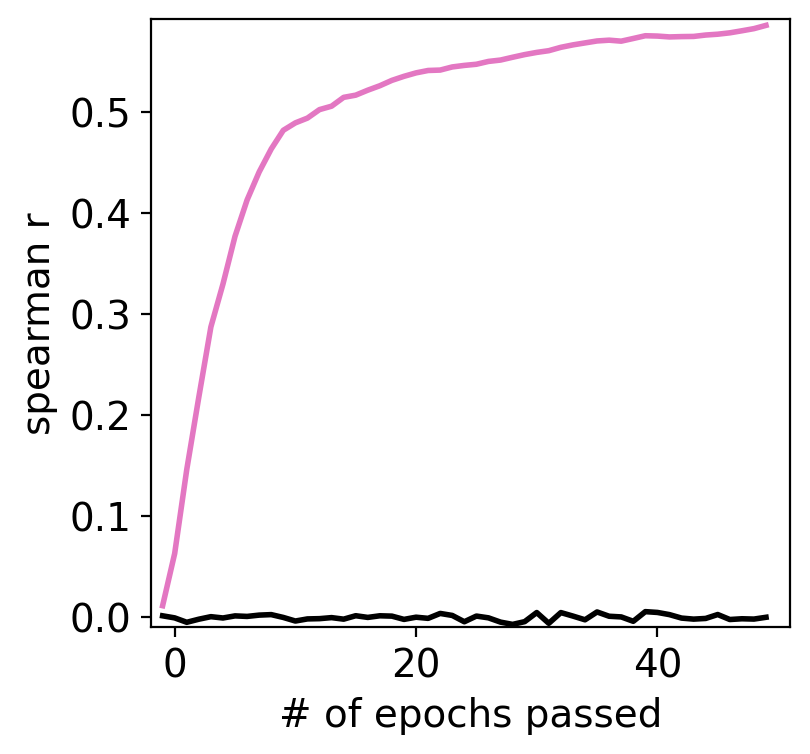

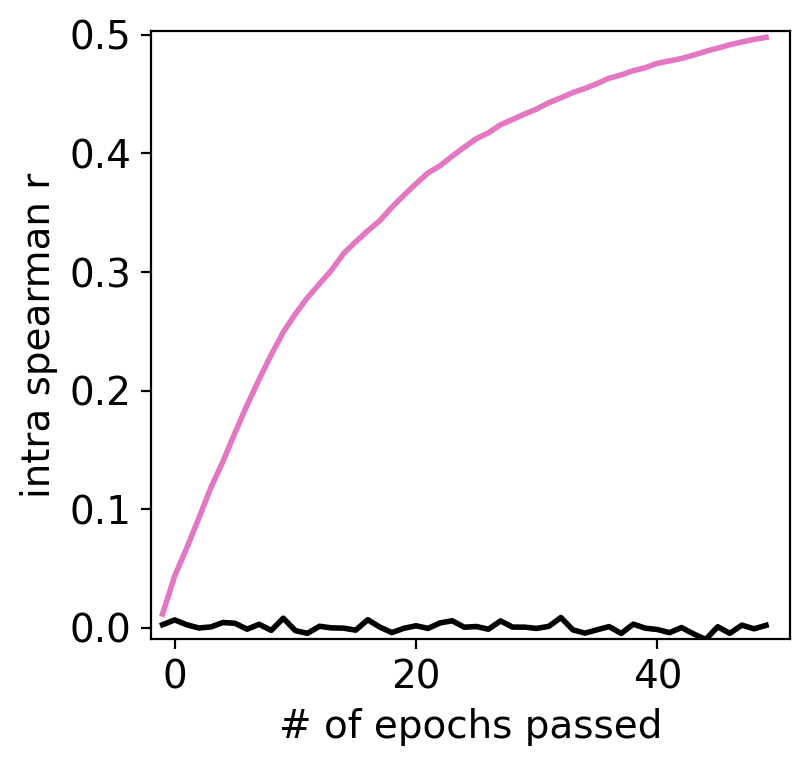

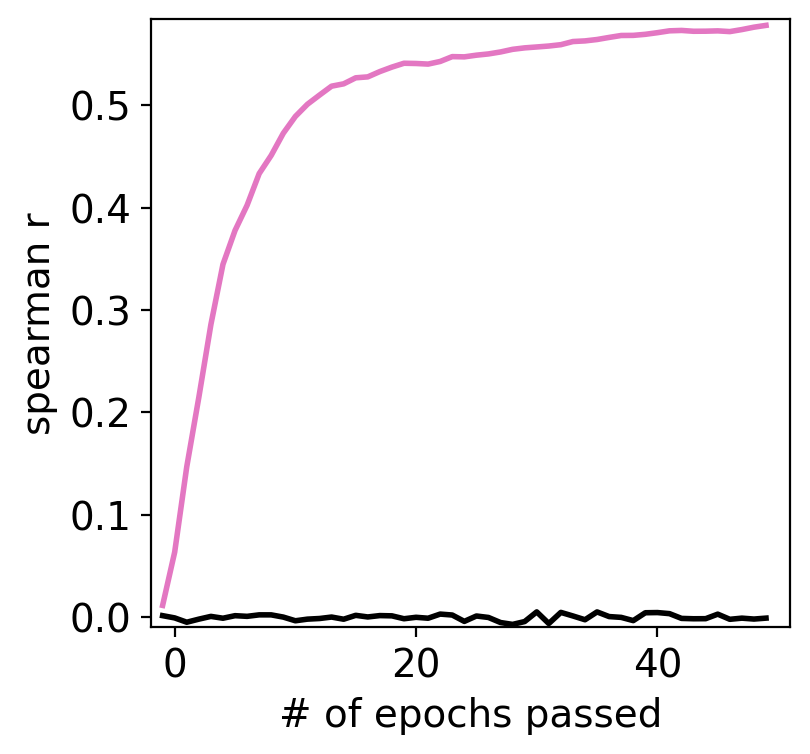

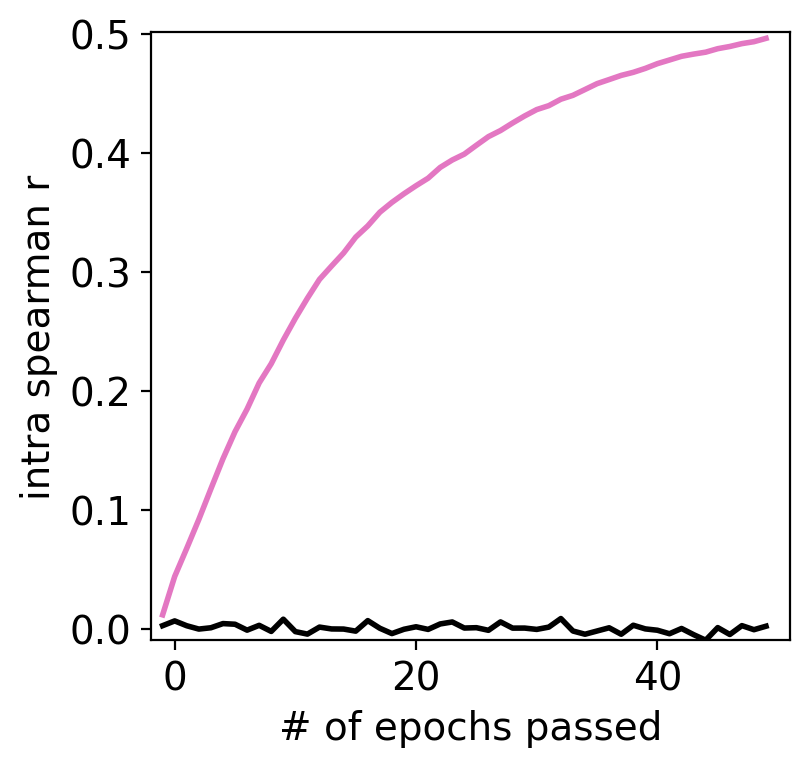

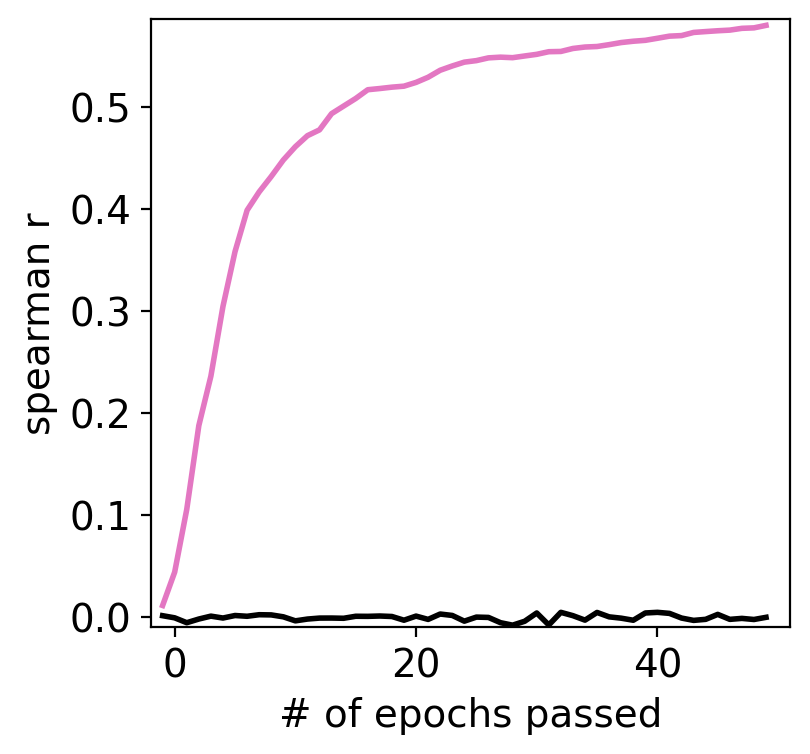

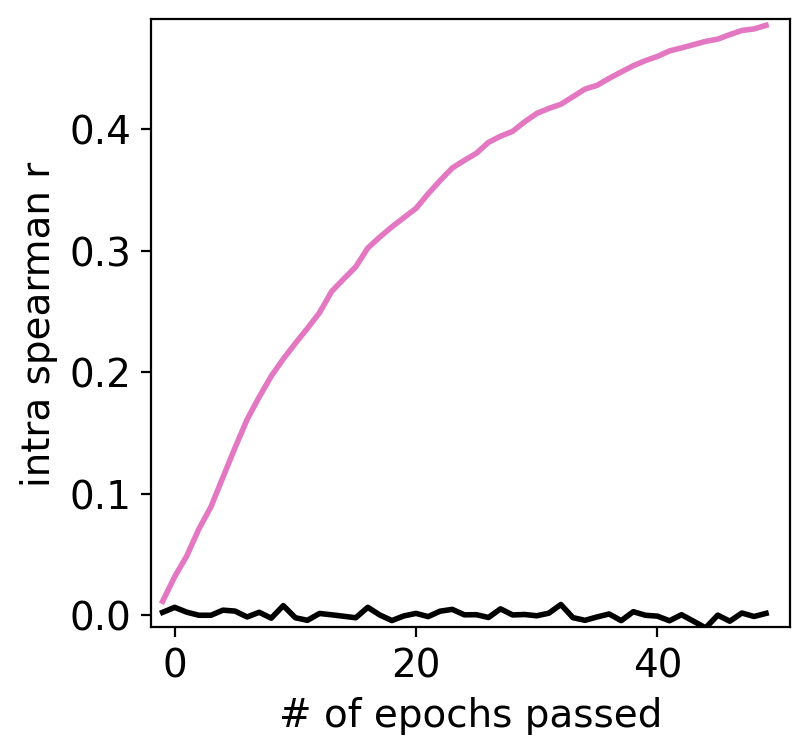

In [29]:
# define the held out sample
final_rs = pd.DataFrame(columns=['seed','r','p','pr','pp'])
final_rs_intra = pd.DataFrame(columns=['seed','r','p','pr','pp'])
for held_out in range(len(samples)):
    # instantiate the model, input and output will be the same
    model_rev_all = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    model_rev = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    # now perform the simulation
    np.random.seed(seed)
    # artifically set the g2g matrix
    input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
    input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)
    model_rev_all.set_g2g(torch.from_numpy(input_g2g))
    model_rev_all.set_g2g_intra(torch.from_numpy(input_g2g))
    input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
    input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)
    model_rev.set_g2g(torch.from_numpy(input_g2g))
    model_rev.set_g2g_intra(torch.from_numpy(input_g2g))
    
    # setup the initial optimizer
    optimizer_all = torch.optim.SGD(model_rev_all.parameters(), lr=learning_rate_all, momentum=0)
    optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
    # keep track of the losses per data object
    loss_all, losses_all = None, []
    loss, losses = None, []
    df_rs = pd.DataFrame(columns=['epoch','r','p','pr','pp'])
    df_rs_intra = pd.DataFrame(columns=['epoch','r','p','pr','pp'])
    # train the model
    model_rev_all.train()
    model_rev.train()
    # retrieve the two matrices
    epoch = -1
    g2g = model_rev.conv1.lin.weight.detach().numpy()
    g2g_all = model_rev_all.conv1.lin.weight.detach().numpy()
    r, p = ss.spearmanr(g2g.flatten(), g2g_all.flatten())
    pr, pp = ss.spearmanr(np.random.choice(g2g.flatten(), size=np.product(g2g.shape)),
                          np.random.choice(g2g_all.flatten(), size=np.product(g2g_all.shape)))
    df_rs.loc[df_rs.shape[0]] = epoch, r, p, pr, pp
    # now for the intra version
    g2g = model_rev.lin.weight.detach().numpy()
    g2g_all = model_rev_all.lin.weight.detach().numpy()
    r, p = ss.spearmanr(g2g.flatten(), g2g_all.flatten())
    pr, pp = ss.spearmanr(np.random.choice(g2g.flatten(), size=np.product(g2g.shape)),
                          np.random.choice(g2g_all.flatten(), size=np.product(g2g_all.shape)))
    df_rs_intra.loc[df_rs_intra.shape[0]] = epoch, r, p, pr, pp
    # work through epochs
    for epoch in tqdm(range(epochs), total=epochs):
        # loop thorugh each data object
        losses_ = []
        losses_all_ = []
        for idx, data in enumerate(data_loader):
            # process separately for the special one
            if idx == held_out:
                # set the appropriate gex
                model_rev.set_gex(data.x)
                # derive the message as well as the mean field approximation
                msg, msg_intra, log_z_mft = model_rev(data.edge_index, 1)
                # compute the loss and track it
                loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model_rev.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model_rev.gex))) )
                losses_.append(loss.detach().numpy()[0][0])
                # derive the gradients, update, and clear
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # repeatedly force a normalization
                model_rev.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.conv1.lin.weight), requires_grad=True)
                model_rev.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.lin.weight), requires_grad=True)
                optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
            else:
                # set the appropriate gex
                model_rev_all.set_gex(data.x)
                # derive the message as well as the mean field approximation
                msg, msg_intra, log_z_mft = model_rev_all(data.edge_index, 1)
                # compute the loss and track it
                loss_all = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model_rev_all.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model_rev_all.gex))) )
                losses_all_.append(loss_all.detach().numpy()[0][0])
                # derive the gradients, update, and clear
                loss_all.backward()
                optimizer_all.step()
                optimizer_all.zero_grad()
                # repeatedly force a normalization
                model_rev_all.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev_all.conv1.lin.weight), requires_grad=True)
                model_rev_all.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev_all.lin.weight), requires_grad=True)
                optimizer_all = torch.optim.SGD(model_rev_all.parameters(), lr=learning_rate_all, momentum=0)
        # now take the average loss of the objects
        losses.append(np.mean(losses_))
        losses_all.append(np.mean(losses_all_))
    
        # retrieve the two matrices
        g2g = model_rev.conv1.lin.weight.detach().numpy()
        g2g_all = model_rev_all.conv1.lin.weight.detach().numpy()
        r, p = ss.spearmanr(g2g.flatten(), g2g_all.flatten())
        pr, pp = ss.spearmanr(np.random.choice(g2g.flatten(), size=np.product(g2g.shape)),
                              np.random.choice(g2g_all.flatten(), size=np.product(g2g_all.shape)))
        df_rs.loc[df_rs.shape[0]] = epoch, r, p, pr, pp
        # now for the intra version
        g2g = model_rev.lin.weight.detach().numpy()
        g2g_all = model_rev_all.lin.weight.detach().numpy()
        r, p = ss.spearmanr(g2g.flatten(), g2g_all.flatten())
        pr, pp = ss.spearmanr(np.random.choice(g2g.flatten(), size=np.product(g2g.shape)),
                              np.random.choice(g2g_all.flatten(), size=np.product(g2g_all.shape)))
        df_rs_intra.loc[df_rs_intra.shape[0]] = epoch, r, p, pr, pp
    
    # derive the correlation over time
    fig, ax = plt.subplots(figsize=[4.1, 4])
    ax.grid(False)
    ax.plot(df_rs['epoch'], df_rs['r'], color='tab:pink', lw=2)
    ax.plot(df_rs['epoch'], df_rs['pr'], color='k', lw=2, linestyle='-')
    ax.set_xlim(-2, epochs+1)
    ax.set_ylim(-0.01, max(df_rs['r'])*1.01)
    ax.set(xlabel='# of epochs passed', ylabel='spearman r')
    
    # derive the correlation over time
    fig, ax = plt.subplots(figsize=[4.1, 4])
    ax.grid(False)
    ax.plot(df_rs['epoch'], df_rs_intra['r'], color='tab:pink', lw=2)
    ax.plot(df_rs['epoch'], df_rs_intra['pr'], color='k', lw=2, linestyle='-')
    ax.set_xlim(-2, epochs+1)
    ax.set_ylim(-0.01, max(df_rs_intra['r'])*1.01)
    ax.set(xlabel='# of epochs passed', ylabel='intra spearman r')
    
    # add on the final rhos
    final_rs.loc[final_rs.shape[0]] = [seed] + df_rs.iloc[-1, 1:].tolist()
    final_rs_intra.loc[final_rs_intra.shape[0]] = [seed] + df_rs_intra.iloc[-1, 1:].tolist()

/loc/scratch/7949135/ipykernel_14582/36777016.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='cat', y='r', data=df, ci=68, capsize=0.3, errwidth=2, linewidth=2, errcolor='k', edgecolor='k',
/loc/scratch/7949135/ipykernel_14582/36777016.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cat', y='r', data=df, ci=68, capsize=0.3, errwidth=2, linewidth=2, errcolor='k', edgecolor='k',
/loc/scratch/7949135/ipykernel_14582/36777016.py:8: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x='cat', y='r', data=df, ci=68, capsize=0.3, errwidth=2, linewidth=2, errcolor='k', edgecolor='k',
/loc/scratch/7949135/ipykernel_14582/36777016.py:8: FutureWarning: 

The `errwidth` parameter 

MannwhitneyuResult(statistic=16.0, pvalue=0.02857142857142857)

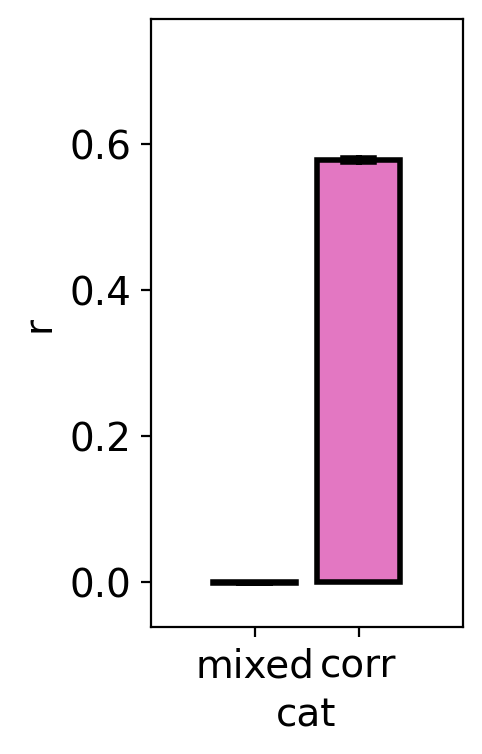

In [30]:
# gather the samples
df1 = pd.DataFrame(final_rs['r'].values, columns=['r']); df1['cat'] = 'corr'
df2 = pd.DataFrame(final_rs['pr'].values, columns=['r']); df2['cat'] = 'mixed'
df = pd.concat([df1, df2], axis=0)
# create a bar plot or box plot
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='cat', y='r', data=df, ci=68, capsize=0.3, errwidth=2, linewidth=2, errcolor='k', edgecolor='k',
            saturation=1, order=['mixed','corr'], palette=['lightgray','tab:pink'])
ax.set_xlim(-1, 2)
ymin, ymax = ax.get_ylim()
ystep = ymax - ymin
ax.set_ylim(ymin-ystep*0.05, ymax+ystep*0.25)
ss.mannwhitneyu(df1['r'], df2['r'])

/loc/scratch/7949135/ipykernel_14582/1830362991.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='cat', y='r', data=df, ci=68, capsize=0.3, errwidth=2, linewidth=2, errcolor='k', edgecolor='k',
/loc/scratch/7949135/ipykernel_14582/1830362991.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cat', y='r', data=df, ci=68, capsize=0.3, errwidth=2, linewidth=2, errcolor='k', edgecolor='k',
/loc/scratch/7949135/ipykernel_14582/1830362991.py:8: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x='cat', y='r', data=df, ci=68, capsize=0.3, errwidth=2, linewidth=2, errcolor='k', edgecolor='k',
/loc/scratch/7949135/ipykernel_14582/1830362991.py:8: FutureWarning: 

The `errwidth` pa

MannwhitneyuResult(statistic=16.0, pvalue=0.02857142857142857)

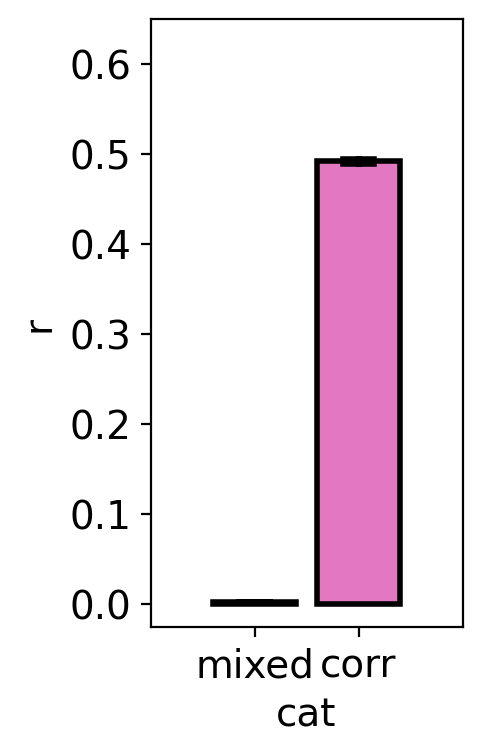

In [31]:
# gather the samples
df1 = pd.DataFrame(final_rs_intra['r'].values, columns=['r']); df1['cat'] = 'corr'
df2 = pd.DataFrame(final_rs_intra['pr'].values, columns=['r']); df2['cat'] = 'mixed'
df = pd.concat([df1, df2], axis=0)
# create a bar plot or box plot
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='cat', y='r', data=df, ci=68, capsize=0.3, errwidth=2, linewidth=2, errcolor='k', edgecolor='k',
            saturation=1, order=['mixed','corr'], palette=['lightgray','tab:pink'])
ax.set_xlim(-1, 2)
ymin, ymax = ax.get_ylim()
ystep = ymax - ymin
ax.set_ylim(ymin-ystep*0.05, ymax+ystep*0.25)
ss.mannwhitneyu(df1['r'], df2['r'])

In [32]:
print()